# 2019 Data Science Bowl
## A Simple Introduction

tl;dr

*In this challenge, you’ll use anonymous gameplay data, including knowledge of videos watched and games played, from the PBS KIDS Measure Up! app, a game-based learning tool developed as a part of the CPB-PBS Ready To Learn Initiative with funding from the U.S. Department of Education. Competitors will be challenged to predict scores on in-game assessments and create an algorithm that will lead to better-designed games and improved learning outcomes. *

**
Note that this is a synchronous rerun code competition and the private test set has approximately 8MM rows. You should be mindful of memory in your notebooks to avoid submission errors.** 😅

In [253]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from IPython.display import HTML
import warnings
pd.set_option('max_columns', 100)
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
my_pal = sns.color_palette(n_colors=10)

First we will see what files we are given to work with. Note the `train.csv` file is quite large at 3.7G.
From the data description we know:
- `train.csv` & `test.csv` : These are the main data files which contain the gameplay events.
- `specs.csv` : This file gives the specification of the various event types.
- `train_labels.csv` : This file demonstrates how to compute the ground truth for the assessments in the training set.
- `sample_submission.csv` : A sample submission in the correct format.

In [193]:
!ls -GFlash ../input/data-science-bowl-2019/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [206]:
# Read in the data CSV files
train = pd.read_csv('train\\train.csv')
print(train)
train_labels = pd.read_csv('C:\\Users\\Owner\\Downloads\\train_labels.csv')
print(train_labels)
test = pd.read_csv('test\\test.csv')
print(test)
specs = pd.read_csv('C:\\Users\\Owner\\Downloads\\specs.csv')
print(specs)
ss = pd.read_csv('C:\\Users\\Owner\\Downloads\\sample_submission.csv')
print(ss)

          event_id      game_session                 timestamp  \
0         27253bdc  45bb1e1b6b50c07b  2019-09-06T17:53:46.937Z   
1         27253bdc  17eeb7f223665f53  2019-09-06T17:54:17.519Z   
2         77261ab5  0848ef14a8dc6892  2019-09-06T17:54:56.302Z   
3         b2dba42b  0848ef14a8dc6892  2019-09-06T17:54:56.387Z   
4         1bb5fbdb  0848ef14a8dc6892  2019-09-06T17:55:03.253Z   
...            ...               ...                       ...   
11341037  ab3136ba  c09b94eebfdf50a6  2019-10-10T15:11:15.584Z   
11341038  27253bdc  6ad8ab25003ef1b0  2019-10-10T15:12:17.364Z   
11341039  27253bdc  71904dca23b982c6  2019-10-10T15:13:04.713Z   
11341040  27253bdc  2267b18f069e875a  2019-10-10T15:13:54.545Z   
11341041  27253bdc  f31950f549d7c242  2019-10-10T15:15:12.483Z   

                                                 event_data installation_id  \
0                    {"event_code": 2000, "event_count": 1}        0001e90f   
1                    {"event_code": 2000, "event_

    installation_id  accuracy_group
0          00abaee7               3
1          01242218               3
2          017c5718               3
3          01a44906               3
4          01bc6cb6               3
..              ...             ...
995        fee254cf               3
996        ff57e602               3
997        ffc73fb2               3
998        ffe00ca8               3
999        ffe774cc               3

[1000 rows x 2 columns]


Because the training data is so large, we will take a random sample of it for plotting. Since we are doing this at random it will speed up the time it takes to plot, and should still give us a a good view of the data's format.

In [208]:
train_ = train.sample(10000)
print(train_)

         event_id      game_session                 timestamp  \
686060   3323d7e9  8307acface5b49d2  2019-09-22T05:35:47.907Z   
5823987  f3cd5473  fc6ce49e848c8369  2019-09-24T22:11:31.015Z   
858187   76babcde  bd5635afe5ee847c  2019-09-26T20:34:59.411Z   
2684041  4ef8cdd3  416a7c56c17857bd  2019-10-04T18:11:48.831Z   
2850398  e9c52111  558a54e57238218a  2019-10-11T15:02:35.138Z   
...           ...               ...                       ...   
3909936  71e712d8  8c1d3fc12a6ca14d  2019-08-19T23:36:03.437Z   
3680905  3ee399c3  e9ce6069b5c6684e  2019-09-05T01:16:17.605Z   
2825027  5e3ea25a  183a3ecc123ce5e4  2019-09-13T11:56:00.825Z   
87526    a0faea5d  8d760448f1cab044  2019-09-14T20:05:51.039Z   
4591071  5c3d2b2f  87d055f054670239  2019-08-06T13:09:10.621Z   

                                                event_data installation_id  \
686060   {"duration":12518,"misses":0,"round":4,"event_...        0f11e020   
5823987  {"coordinates":{"x":656,"y":212,"stage_width":...     

## The target.
First we will look at the target we intend to predict.

We are told: *The intent of the competition is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment (an incorrect answer is counted as an attempt).*
The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):
- 3: the assessment was solved on the first attempt
- 2: the assessment was solved on the second attempt
- 1: the assessment was solved after 3 or more attempts
- 0: the assessment was never solved


In [226]:
train_labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


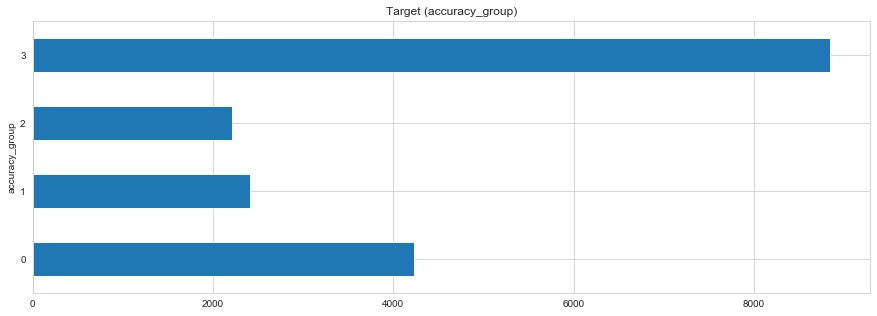

In [227]:
train_labels.groupby('accuracy_group')['game_session'].count() \
    .plot(kind='barh', figsize=(15, 5), title='Target (accuracy_group)')
plt.show()

Thngs to note about the taget:
- Accuracy of 100% goes to group 3
- Accuracy of ~50% goes to group 2
- Not finishing goes to group 0
- Group 1 looks to have the most variation

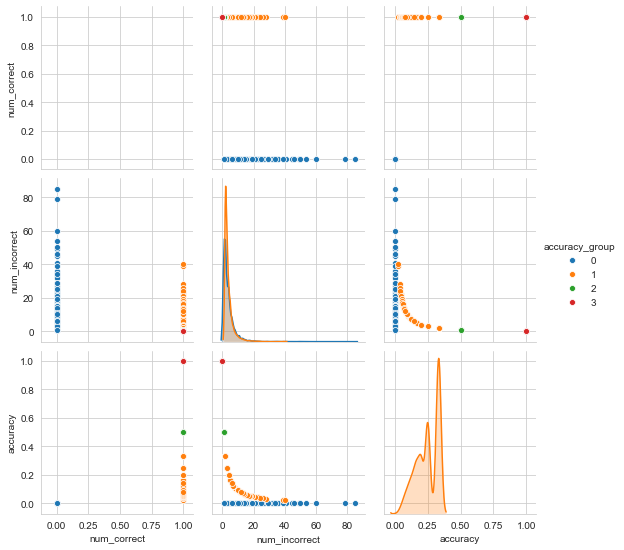

In [228]:
sns.pairplot(train_labels, hue='accuracy_group')
plt.show()

# train.csv / test.csv
The data provided in these files are as follows:
- `event_id` - Randomly generated unique identifier for the event type. Maps to event_id column in specs table.
- `game_session` - Randomly generated unique identifier grouping events within a single game or video play session.
- `timestamp` - Client-generated datetime
- `event_data` - Semi-structured JSON formatted string containing the events parameters. Default fields are: event_count, event_code, and game_time; otherwise - fields are determined by the event type.
- `installation_id` - Randomly generated unique identifier grouping game sessions within a single installed application instance.
- `event_count` - Incremental counter of events within a game session (offset at 1). Extracted from event_data.
- `event_code` - Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.
- `game_time` - Time in milliseconds since the start of the game session. Extracted from event_data.
- `title` - Title of the game or video.
- `type` - Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.
- `world` - The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media. Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).

In [229]:
train.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,event_id_as_int,game_session_as_int,date,hour
0,27253bdc,45bb1e1b6b50c07b,2019-09-06 17:53:46.937000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,656751580,5024642912375324795,2019-09-06,17
1,27253bdc,17eeb7f223665f53,2019-09-06 17:54:17.519000+00:00,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,656751580,1724517957933358931,2019-09-06,17
2,77261ab5,0848ef14a8dc6892,2019-09-06 17:54:56.302000+00:00,"{""version"":""1.0"",""event_count"":1,""game_time"":0...",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,1998985909,596989822637992082,2019-09-06,17
3,b2dba42b,0848ef14a8dc6892,2019-09-06 17:54:56.387000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK,3000738859,596989822637992082,2019-09-06,17
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06 17:55:03.253000+00:00,"{""description"":""Let's build a sandcastle! Firs...",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK,464911323,596989822637992082,2019-09-06,17


## event_id & game_session
They say it's randomly generated, but is that true? Looks to be hex, lets convert it to an integer. Plotting shows nothign really interesting.

In [230]:
train['event_id_as_int'] = train['event_id'].apply(lambda x: int(x, 16))
train['game_session_as_int'] = train['game_session'].apply(lambda x: int(x, 16))

## timestamp
Lets see how many observations we have over time. Are they all in the same/similar time zone?
- Looks like number of observations rises over time. Steep pickup and dropoff at the start/end
- Much less use during the middle of the night hours. Use increases during the day with a slow reduction in use around midnight. We don't know how the timestamp relates to time zones for different users.
- More users on Thursday and Friday. 

In [231]:
# Format and make date / hour features
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['date'] = train['timestamp'].dt.date
train['hour'] = train['timestamp'].dt.hour
train['weekday_name'] = train['timestamp'].dt.weekday_name
# Same for test
test['timestamp'] = pd.to_datetime(test['timestamp'])
test['date'] = test['timestamp'].dt.date
test['hour'] = test['timestamp'].dt.hour
test['weekday_name'] = test['timestamp'].dt.weekday_name

AttributeError: 'DatetimeProperties' object has no attribute 'weekday_name'

In [ ]:
print(f'Train data has shape: {train.shape}')
print(f'Test data has shape: {test.shape}')

In [ ]:
train.groupby('date')['event_id'] \
    .agg('count') \
    .plot(figsize=(15, 3),
         title='Numer of Event Observations by Date',
         color=my_pal[2])
plt.show()
train.groupby('hour')['event_id'] \
    .agg('count') \
    .plot(figsize=(15, 3),
         title='Numer of Event Observations by Hour',
         color=my_pal[1])
plt.show()
train.groupby('weekday_name')['event_id'] \
    .agg('count').T[['Monday','Tuesday','Wednesday',
                     'Thursday','Friday','Saturday',
                     'Sunday']].T.plot(figsize=(15, 3),
                                       title='Numer of Event Observations by Day of Week',
                                       color=my_pal[3])
plt.show()

# event_data
This looks to have most of the interesting data about the event. It is in JSON format which isn't easy to wrangle in a tabular way. We need to be clever when parsing this data. They have already parsed some of this data for us like `event_count` and `event_code`.

In [ ]:
print(train['event_data'][4])
print(train['event_data'][5])

## installation_id *important - predictions are grouped by these*
- Randomly generated unique identifier grouping game sessions within a single installed application instance.
- We will be predicting based off of these IDs
- The training set has exactly 17000 unique `installation_ids`

In [232]:
train['installation_id'].nunique()

17000

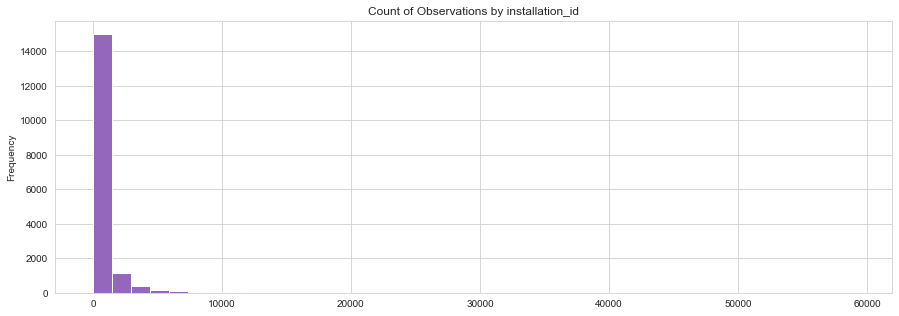

In [233]:
train.groupby('installation_id') \
    .count()['event_id'] \
    .plot(kind='hist',
          bins=40,
          color=my_pal[4],
          figsize=(15, 5),
         title='Count of Observations by installation_id')
plt.show()

Lets take a log transform of this count to we can more easily see what the distribution of counts by `insallation_id` looks like

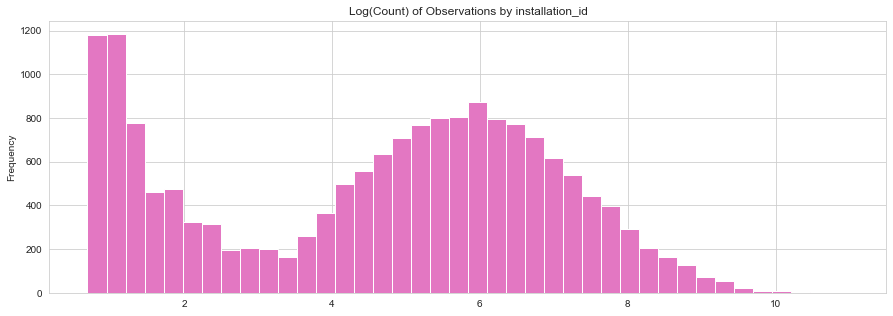

In [234]:
train.groupby('installation_id') \
    .count()['event_id'] \
    .apply(np.log1p) \
    .plot(kind='hist',
          bins=40,
          color=my_pal[6],
         figsize=(15, 5),
         title='Log(Count) of Observations by installation_id')
plt.show()

Lets looks at some of the installation_ids with the highest counts. We see some installation_ids have tens of thousands of observations!

In [235]:
train.groupby('installation_id') \
    .count()['event_id'].sort_values(ascending=False).head(5)

installation_id
f1c21eda    58988
4d7d3d97    32749
d25338cb    31826
cff5a334    30918
c9ea32e9    30402
Name: event_id, dtype: int64

Wow, 50000+ events for a single `installation_id`. Lets take a closer look at the id with the most observations. Not exactly sure what I'm looking at here. But it looks like this `installation_id` spans a long duration (over one month). Could this be installed by a bot? The use history does not look natural.

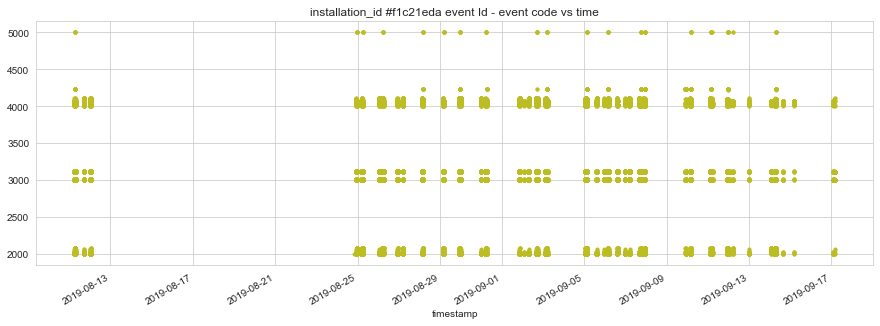

In [236]:
train.query('installation_id == "f1c21eda"') \
    .set_index('timestamp')['event_code'] \
    .plot(figsize=(15, 5),
          title='installation_id #f1c21eda event Id - event code vs time',
         style='.',
         color=my_pal[8])
plt.show()

## event_code
- Identifier of the event 'class'. Unique per game, but may be duplicated across games. E.g. event code '2000' always identifies the 'Start Game' event for all games. Extracted from event_data.

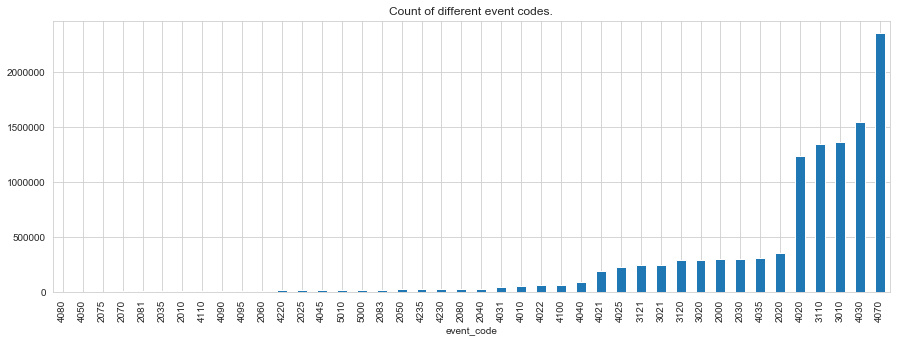

In [237]:
train.groupby('event_code') \
    .count()['event_id'] \
    .sort_values() \
    .plot(kind='bar',
         figsize=(15, 5),
         title='Count of different event codes.')
plt.show()

lets take a closer look at the event codes `4070` and `4030`
- We notice that event 4070 and 4030 always comes with coordinates (x, y) and stage_width.
- Possibly they could be marking acheivements or something related to position on the screen.
These events look like this:
```
{"size":0,"coordinates":{"x":782,"y":207,"stage_width":1015,"stage_height":762},"event_count":55,"game_time":34324,"event_code":4030}
```

## game_time
- Time in milliseconds since the start of the game session. Extracted from event_data.
- The `log1p` transform shows a somewhat normal distribution with a peak at zero.

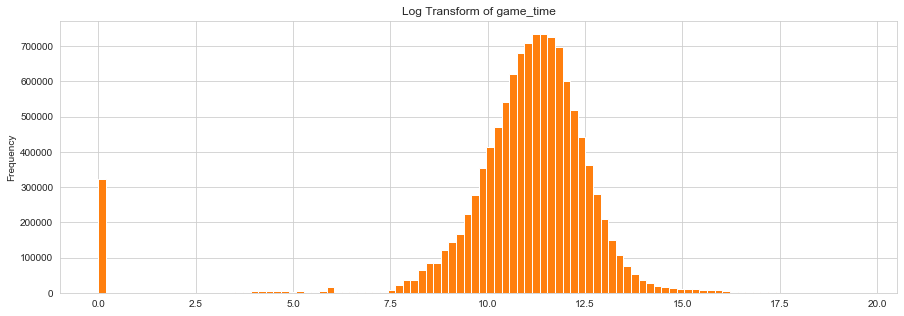

In [238]:
train['game_time'].apply(np.log1p) \
    .plot(kind='hist',
          figsize=(15, 5),
          bins=100,
          title='Log Transform of game_time',
          color=my_pal[1])
plt.show()

## Game/Video titles
- Chow Time is very popular, along with Sandcastle Builder, Scrub-A-Dub, and Bottle Filler
- After that there is a steep dropoff
- Assessment's are in the 200000 count range.
- Games with levels are less frequent
- Some games or titles (maybe videos?) at the bottom are very infrequently seen.

Some examples of the top games:
Chow Time:
https://www.youtube.com/watch?v=tvRtFqOqa-Y



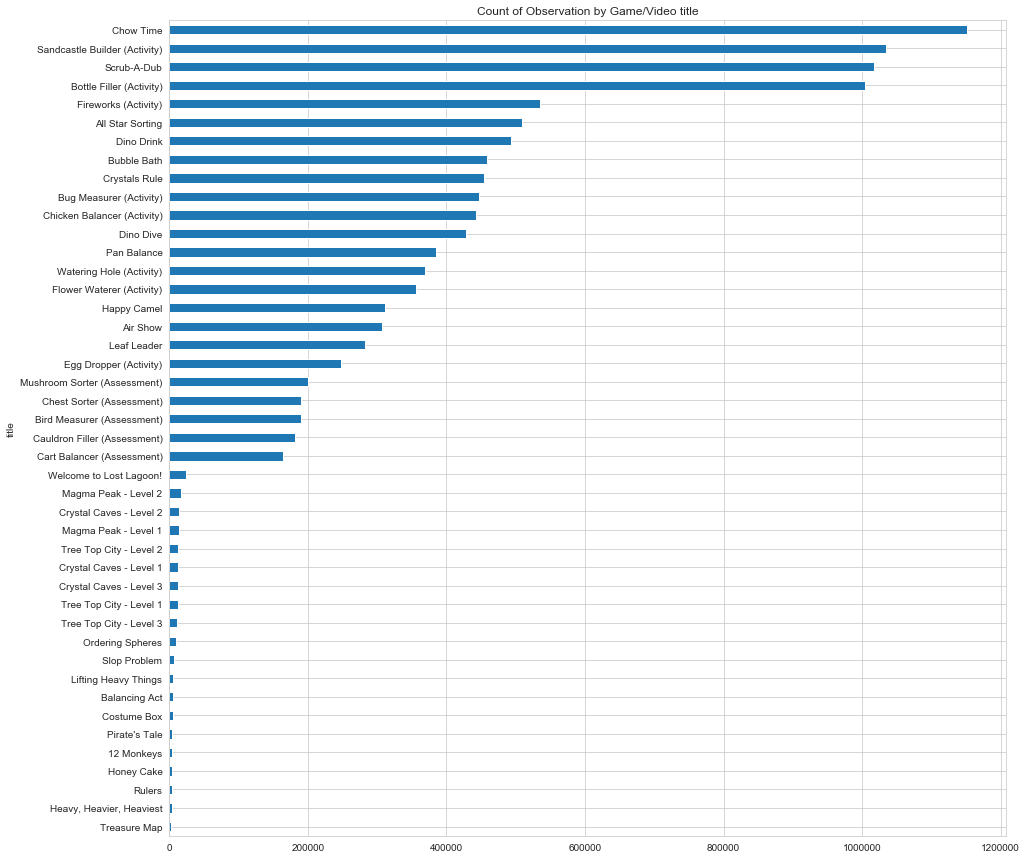

In [239]:
train.groupby('title')['event_id'] \
    .count() \
    .sort_values() \
    .plot(kind='barh',
          title='Count of Observation by Game/Video title',
         figsize=(15, 15))
plt.show()

## Video Examples of the Gameplay
Its helpful to see what the games actually look like. Here are a few youtube videos showing gameplay of the more popular titles.

In [240]:
# Chow Time Video
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/tvRtFqOqa-Y" frameborder="0" allow="accelerometer; \
        autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

In [241]:
# Scrub-a-Dub
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/kkNzO2QzWaQ" frameborder="0" allow="accelerometer; \
    autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Game/Video type
- Media type of the game or video. Possible values are: 'Game', 'Assessment', 'Activity', 'Clip'.
- Most are games, next are activities
- Clips are the least common

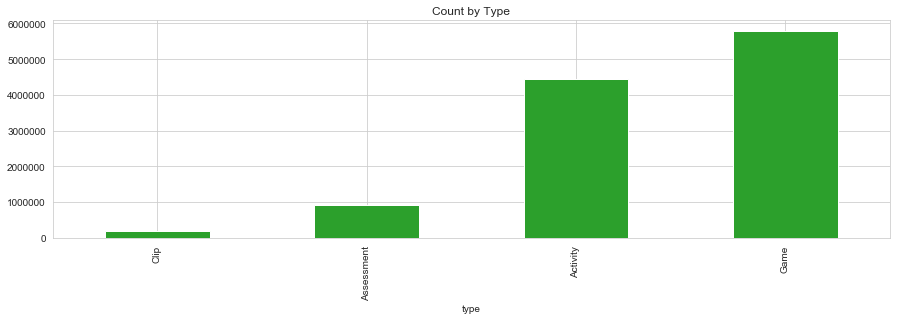

In [242]:
train.groupby('type')['event_id'] \
    .count() \
    .sort_values() \
    .plot(kind='bar',
          figsize=(15, 4),
          title='Count by Type',
          color=my_pal[2])
plt.show()

## World
- The section of the application the game or video belongs to. Helpful to identify the educational curriculum goals of the media.
- Possible values are: 'NONE' (at the app's start screen), TREETOPCITY' (Length/Height), 'MAGMAPEAK' (Capacity/Displacement), 'CRYSTALCAVES' (Weight).

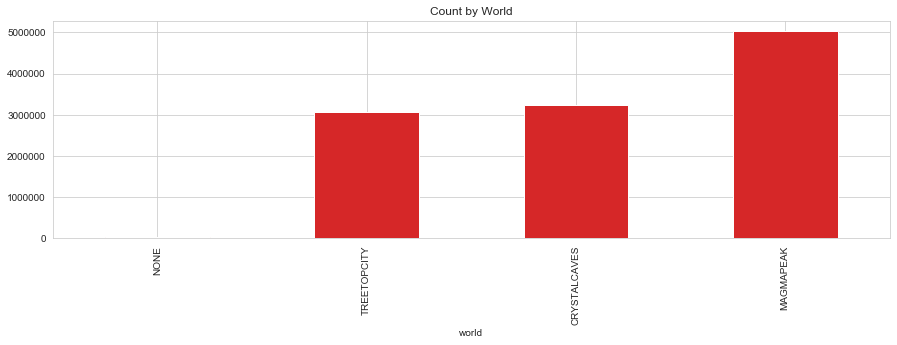

In [243]:
train.groupby('world')['event_id'] \
    .count() \
    .sort_values() \
    .plot(kind='bar',
          figsize=(15, 4),
          title='Count by World',
          color=my_pal[3])
plt.show()

## log(game_time) vs game/video categories 

In [266]:
train['log1p_game_time'] = train['game_time'].apply(np.log1p)

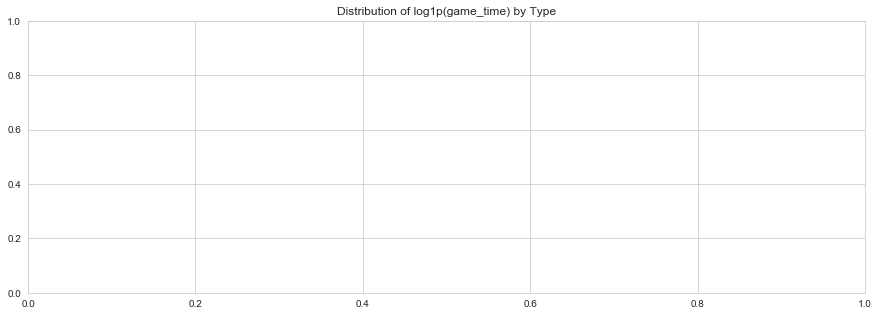

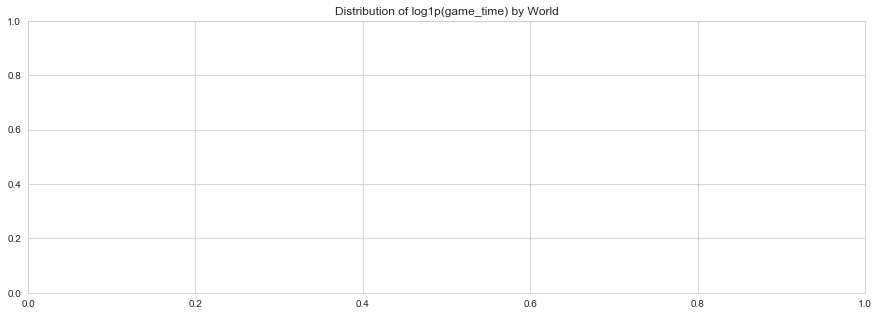

In [270]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.catplot(x="type", y="log1p_game_time",
            data=train.sample(10000), alpha=0.5, ax=ax);
ax.set_title('Distribution of log1p(game_time) by Type')
plt.close()
plt.show()
fig, ax = plt.subplots(figsize=(15, 5))
sns.catplot(x="world", y="log1p_game_time",
            data=train.sample(10000), alpha=0.5, ax=ax);
ax.set_title('Distribution of log1p(game_time) by World')
plt.close()
plt.show()

# specs.csv
The `specs.csv` gives us more information about what the event ids represent.
- There are 386 unique event_ids
- 168 unique info
- 191 unique args
- info and args columns

In [262]:
specs.head()

,event_id,info,args
0,2b9272f4,The end of system-initiated feedback (Correct)...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
1,df4fe8b6,The end of system-initiated feedback (Incorrec...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
2,3babcb9b,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
3,7f0836bf,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
4,ab3136ba,The end of system-initiated instruction event ...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."


In [263]:
specs.describe()

,event_id,info,args
count,386,386,386
unique,386,168,191
top,28f975ea,This event occurs when the player clicks on th...,"[{""name"":""game_time"",""type"":""int"",""info"":""mill..."
freq,1,17,25


# Baseline Model

We are told in the data description that:
- The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set.
- Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. 
- If the attempt was correct, it contains "correct":true.

We also know:
- The intent of the competition is to **use the gameplay data to forecast how many attempts a child will take to pass a given assessment** (an incorrect answer is counted as an attempt). 
- Each application install is represented by an installation_id. This will typically correspond to one child, but you should expect noise from issues such as shared devices.
- **In the training set, you are provided the full history of gameplay data.**
- In the test set, we have truncated the history after the start event of a single assessment, chosen randomly, for which you must predict the number of attempts.
- Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.

In [264]:
# First Attempt... still working to fully understand the problem
from sklearn.model_selection import train_test_split

# Define cleared or not cleared
# 
train['cleared'] = True
train.loc[train['event_data'].str.contains('false') & train['event_code'].isin([4100, 4110]), 'cleared'] = False

test['cleared'] = True
test.loc[test['event_data'].str.contains('false') & test['event_code'].isin([4100, 4110]), 'cleared'] = False

aggs = {'hour': ['max','min','mean'],
        'cleared': ['mean']}

train_aggs = train.groupby('installation_id').agg(aggs)
test_aggs = test.groupby('installation_id').agg(aggs)
train_aggs = train_aggs.reset_index()
test_aggs = test_aggs.reset_index()
train_aggs.columns = ['_'.join(col).strip() for col in train_aggs.columns.values]
test_aggs.columns = ['_'.join(col).strip() for col in test_aggs.columns.values]
train_aggs = train_aggs.rename(columns={'installation_id_' : 'installation_id'})

KeyError: "Column 'hour' does not exist!"

In [265]:
# Hmmm... not 1:1
train_aggs.merge(train_labels[['installation_id','accuracy_group']],
                 how='left')

MergeError: No common columns to perform merge on. Merge options: left_on=None, right_on=None, left_index=False, right_index=False